In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os 
import pickle 
import cortex
import sys
import nibabel as nib
from nibabel.freesurfer.io import read_morph_data, write_morph_data
import cortex

In [17]:
subj = 'sub-46'
target = 'V2' # or 'V3'
source = 'V1'
hemi = 'rh' # or 'rh'
atlas = 'manual' # or 'benson'
delineation = 'manualdelin'
denoising = 'nordic' # or 'nordic_sm4
task = 'RET' # or 'RET2' or 'Resting_State'
best_fit = f'/Users/federicacardillo/Documents/GitHub/OBJ_MCMC_CF/OBJ_MCMC_CF/results/{subj}/{hemi}/{target}->{source}/best_fits.csv' 
MAIN_PATH = '/Volumes/FedericaCardillo/pre-processing/projects/PROJECT_EGRET-AAA/derivatives'
freesurfer = f"{MAIN_PATH}/freesurfer"
labels = f"{freesurfer}/{subj}/label/{hemi}.{delineation}.label"
supervoxel = True 

In [18]:
# EXTRACT THE POPULATION RECEPTIVE FIELD PROPERTIES 
# 1. Load the file with the best fits
best_fit = pd.read_csv(best_fit)
best_fit

Target Vertex Index  Source Vertex Index  Best Sigma  \
0                    6747                 3618    0.689796   
1                    7407                 4054    0.689796   
2                    7370                 4054    0.689796   
3                    6732                 3618    0.689796   
4                    6170                 3618    0.689796   
...                   ...                  ...         ...   
1751                  254               101462    0.476531   
1752                  248                  108    0.476531   
1753               101014               103748    0.689796   
1754                  255               101462    0.050000   
1755                  256                  113    0.050000   

      Best Variance Explained  \
0                    0.594772   
1                    0.568528   
2                    0.613136   
3                    0.706881   
4                    0.651596   
...                       ...   
1751                 0.850923   
1752                 0.940504   
1753                 0.911835   
1754                 0.961972   
1755                 0.979678   

                                       Gaussian Weights  
0     {4548: 8.625511665152064e-06, 4533: 1.04973378...  
1     {4548: 1.4503440979392318e-05, 4533: 1.6565551...  
2     {4548: 1.4503440979392318e-05, 4533: 1.6565551...  
3     {4548: 8.625511665152064e-06, 4533: 1.04973378...  
4     {4548: 8.625511665152064e-06, 4533: 1.04973378...  
...                                                 ...  
1751  {4548: 8.916803698483881e-27, 4533: 4.85067153...  
1752  {4548: 3.1783170864883823e-25, 4533: 1.6851146...  
1753  {4548: 5.038806926105033e-14, 4533: 1.13550322...  
1754  {4548: 0.0, 4533: 0.0, 4549: 0.0, 5037: 0.0, 4...  
1755  {4548: 0.0, 4533: 0.0, 4549: 0.0, 5037: 0.0, 4...  

[1756 rows x 5 columns]

(0.0, 1.0)

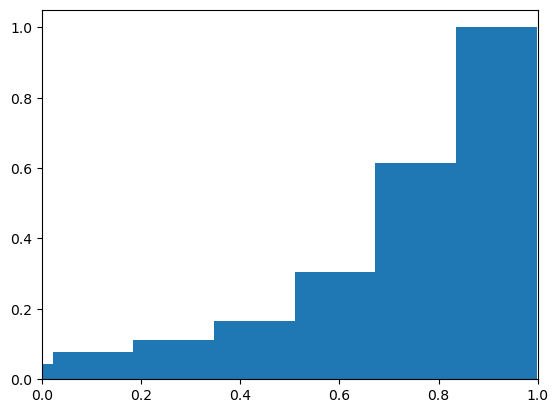

In [19]:
plt.hist(best_fit['Best Variance Explained'], cumulative=True, density=True)
plt.xlim(0,1)

In [20]:
# 2. Load the pickle file with the pRF mapping results
class PRFModel:
    def __init__(self, r2, size, ecc, angle):
        self.r2 = r2        
        self.size = size
        self.ecc = ecc    
        self.angle = angle     

def load_pickle_file(filepath):
    if not os.path.isfile(filepath):
        raise FileNotFoundError(f"File not found: {filepath}")
    with open(filepath, 'rb') as file: 
        return pickle.load(file)

def load_prf_params(subj, main_path, atlas, denoising, task):
    filepath = os.path.join(main_path, f'pRFM/{subj}/ses-02/{denoising}/model-{atlas}-nelder-mead-GM_desc-prf_params_{task}.pkl') 
    pkl_data = load_pickle_file(filepath)                       
    prf_params = pkl_data['model'].iterative_search_params     
    prf_voxels = np.where(pkl_data['rois_mask'] == 1)[0]    ## CHECK THIS.  
    prf_voxels= prf_voxels
    return prf_params, prf_voxels

def filter_prf_data(prf_params, prf_voxels):
    return PRFModel(
        r2=prf_params[:, 7],                                              
        size=prf_params[:, 2],                                              
        ecc=np.sqrt(prf_params[:, 1]**2 + prf_params[:, 0]**2),      
        angle=np.arctan2(prf_params[:, 1], prf_params[:, 0]))

# 3. Assign pRF propreties
def extract_prf_properties(subj, MAIN_PATH, atlas, denoising, task, csv_path):
    # best_fit = pd.read_csv(best_fit)
    prf_params, prf_voxels = load_prf_params(subj, MAIN_PATH, atlas, denoising, task)
    prf_model = filter_prf_data(prf_params, prf_voxels)
    lh_c = read_morph_data(f'{freesurfer}/{subj}/surf/lh.curv')
    numel_lh = lh_c.shape[0]
    #voxel_to_ecc = dict(zip(prf_voxels, prf_model.ecc))
    #voxel_to_angle = dict(zip(prf_voxels, prf_model.angle))

    if hemi == 'rh':
        prf_voxels_rh = prf_voxels[prf_voxels >= numel_lh] # [0 1 2 ... 248451 248457 248464] that are higher than 125206 = [125206 125207 125208 ... 248451 248457 248464]
        prf_voxels_rh_adjusted = prf_voxels_rh - numel_lh # [0 1 2 ... 123245 123251 123258]
        prf_ecc_rh = prf_model.ecc[prf_voxels >= numel_lh] 
        # Eccentricitites go from [ 4.23861239  4.16218227  4.22745697 ...  3.07043493  4.73220189 10.86407027] to [ 2.70803117  2.87556788  2.90106839 ...  3.07043493  4.73220189 10.86407027
        prf_angle_rh = prf_model.angle[prf_voxels >= numel_lh]
        voxel_to_ecc = dict(zip(prf_voxels_rh_adjusted, prf_ecc_rh))
        voxel_to_angle = dict(zip(prf_voxels_rh_adjusted, prf_angle_rh))
    else: 
        voxel_to_ecc = dict(zip(prf_voxels, prf_model.ecc))
        voxel_to_angle = dict(zip(prf_voxels, prf_model.angle))
    
    best_fit['Source Eccentricity'] = best_fit['Source Vertex Index'].map(voxel_to_ecc)
    best_fit['Source Polar Angle'] = best_fit['Source Vertex Index'].map(voxel_to_angle)
   #best_fit['Target Eccentricity'] = best_fit['Target Vertex Index'].map(voxel_to_ecc)
   #best_fit['Target Polar Angle'] = best_fit['Target Vertex Index'].map(voxel_to_angle)

    output = f'/Users/federicacardillo/Documents/GitHub/OBJ_MCMC_CF/OBJ_MCMC_CF/results/{subj}/{hemi}/{target}->{source}/best_fits_prf.csv'
    best_fit.to_csv(output, index=False)
    
    return best_fit

best_fit_prf = extract_prf_properties(subj, MAIN_PATH, atlas, denoising, task, best_fit)
best_fit_prf

Target Vertex Index  Source Vertex Index  Best Sigma  \
0                    6747                 3618    0.689796   
1                    7407                 4054    0.689796   
2                    7370                 4054    0.689796   
3                    6732                 3618    0.689796   
4                    6170                 3618    0.689796   
...                   ...                  ...         ...   
1751                  254               101462    0.476531   
1752                  248                  108    0.476531   
1753               101014               103748    0.689796   
1754                  255               101462    0.050000   
1755                  256                  113    0.050000   

      Best Variance Explained  \
0                    0.594772   
1                    0.568528   
2                    0.613136   
3                    0.706881   
4                    0.651596   
...                       ...   
1751                 0.850923   
1752                 0.940504   
1753                 0.911835   
1754                 0.961972   
1755                 0.979678   

                                       Gaussian Weights  Source Eccentricity  \
0     {4548: 8.625511665152064e-06, 4533: 1.04973378...             5.230338   
1     {4548: 1.4503440979392318e-05, 4533: 1.6565551...             5.836337   
2     {4548: 1.4503440979392318e-05, 4533: 1.6565551...             5.836337   
3     {4548: 8.625511665152064e-06, 4533: 1.04973378...             5.230338   
4     {4548: 8.625511665152064e-06, 4533: 1.04973378...             5.230338   
...                                                 ...                  ...   
1751  {4548: 8.916803698483881e-27, 4533: 4.85067153...             0.848573   
1752  {4548: 3.1783170864883823e-25, 4533: 1.6851146...             1.337550   
1753  {4548: 5.038806926105033e-14, 4533: 1.13550322...             0.683107   
1754  {4548: 0.0, 4533: 0.0, 4549: 0.0, 5037: 0.0, 4...             0.848573   
1755  {4548: 0.0, 4533: 0.0, 4549: 0.0, 5037: 0.0, 4...             1.146277   

      Source Polar Angle  
0               2.446468  
1               2.521572  
2               2.521572  
3               2.446468  
4               2.446468  
...                  ...  
1751           -2.342001  
1752           -2.171633  
1753           -2.490971  
1754           -2.342001  
1755           -2.216846  

[1756 rows x 7 columns]

In [21]:
# ECCENTRICITY
# Assign to each voxel in the target area the eccentricity of the best fit in the source area 
target_idx = best_fit_prf['Target Vertex Index'].values.astype(int)
target_ecc = best_fit_prf['Source Eccentricity'].values
curv = read_morph_data(f'{freesurfer}/{subj}/surf/{hemi}.curv')
# curv = read_morph_data(f'{freesurfer}/{subj}/surf/lh.curv')
masked_ecc = np.zeros(curv.shape[0])
masked_ecc[:] = 50 
masked_ecc[target_idx] = target_ecc
ecc_output = f'{freesurfer}/{subj}/surf/{hemi}.ecc_{target}{source}'
write_morph_data(ecc_output, masked_ecc)

# POLAR ANGLE 
target_idx = best_fit_prf['Target Vertex Index'].values.astype(int)
target_pol = best_fit_prf['Source Polar Angle'].values
masked_pol = np.zeros(curv.shape[0])
masked_pol[:] = 50 
masked_pol[target_idx] = target_pol
pol_output = f'{freesurfer}/{subj}/surf/{hemi}.pol_{target}{source}'
write_morph_data(pol_output, masked_pol)
print(masked_pol)

# VARIANCE EXPLAINED 
target_idx = best_fit_prf['Target Vertex Index'].values.astype(int)
target_ve = best_fit_prf['Best Variance Explained'].values
masked_ve = np.zeros(curv.shape[0])
masked_ve[:] = 50 
masked_ve[target_idx] = target_ve
ve_output = f'{freesurfer}/{subj}/surf/{hemi}.ve_{target}{source}'
write_morph_data(ve_output, masked_ve)

# SIGMA 
target_idx = best_fit_prf['Target Vertex Index'].values.astype(int)
target_sigma = best_fit_prf['Best Sigma'].values
masked_sigma = np.zeros(curv.shape[0])
masked_sigma[:] = 50 
masked_sigma[target_idx] = target_sigma
sigma_output = f'{freesurfer}/{subj}/surf/{hemi}.sigma_{target}{source}'
write_morph_data(sigma_output, masked_sigma)

[-1.77496369 -1.77496369 -1.95636248 ... 50.         50.
 50.        ]


In [53]:
# GAUSSIAN WEIGHTS 
best_fit["Gaussian Weights"] = best_fit["Gaussian Weights"].apply(eval) 
source_idx_weights = []
for _, row in best_fit.iterrows():
    weight_dict = row["Gaussian Weights"]
    for source_idx, weight in weight_dict.items():
        source_idx_weights.append([source_idx, weight])  # Store as [source_vertex, weight]

weights_df = pd.DataFrame(source_idx_weights, columns=["Source Vertex Index", "Gaussian Weight"])
wights_output = f'/Users/federicacardillo/Documents/GitHub/OBJ_MCMC_CF/OBJ_MCMC_CF/results_ONE/{subj}/{hemi}/{target}->{source}/weights.csv'
weights_df.to_csv(wights_output, index=False)

# SIGMA 
single_fit = f"/Users/federicacardillo/Documents/GitHub/OBJ_MCMC_CF/OBJ_MCMC_CF/results_ONE/{subj}/{hemi}/{target}->{source}/individual_fits/all_fits_target_vertex_472.csv" # 117096 all_fits_target_vertex_8686
best_fit_sigma = pd.read_csv(single_fit)
maxVE = best_fit_sigma["Best Variance Explained"].max()
best_fit = best_fit_sigma[best_fit_sigma["Best Variance Explained"] == maxVE]
best_fit_source = best_fit_sigma[best_fit_sigma["Source Vertex Index"] == 5290] # 2559 6023
best_fit_source = best_fit_source.copy()
best_fit_sigma = f"/Users/federicacardillo/Documents/GitHub/OBJ_MCMC_CF/OBJ_MCMC_CF/results_ONE/{subj}/{hemi}/{target}->{source}/individual_fits/bestfit_sigma.csv"
best_fit_source.to_csv(f"/Users/federicacardillo/Documents/GitHub/OBJ_MCMC_CF/OBJ_MCMC_CF/results_ONE/{subj}/{hemi}/{target}->{source}/individual_fits/bestfit_sigma.csv", mode="a", index=False, header=not os.path.exists(best_fit_sigma))

# EXTRACT THE GAUSSIAN WEIGHTS
best_fit_sigma = pd.read_csv(best_fit_sigma)
#best_fits_path = f'/Users/federicacardillo/Documents/GitHub/OBJ_MCMC_CF/OBJ_MCMC_CF/results_ONE/{subj}/{hemi}/V{target_visual_area}->V{source_visual_area}/individual_fits/bestfit_sigma.csv'
#best_fits_sigma = pd.read_csv(best_fits_path)
#best_fits_sigma["Gaussian Weights"] = best_fits_sigma["Gaussian Weights"].values # Convert the "Gaussian Weights" column from string to dictionary
best_fit_sigma["Gaussian Weights"] = best_fit_sigma["Gaussian Weights"].apply(eval)  # Convert to dictionary
source_idx_weights = [] # Extract source vertex indices and their Gaussian weights 
for _, row in best_fit_sigma.iterrows():
    weight_dict = row["Gaussian Weights"]
    for source_idx, weight in weight_dict.items():
        source_idx_weights.append([source_idx, weight])  # Store as [source_vertex, weight]

weights_df = pd.DataFrame(source_idx_weights, columns=["Source Vertex Index", "Gaussian Weight"]) # Panda dataframe
output_weights_sigma = f'/Users/federicacardillo/Documents/GitHub/OBJ_MCMC_CF/OBJ_MCMC_CF/results_ONE/{subj}/{hemi}/{target}->{source}/weights+sigma.csv'
weights_df.to_csv(output_weights_sigma, index=False)

# PLOT THE GAUSSIAN WEIGHTS
# weights_data = pd.read_csv(output_weights_sigma)
weights_data = pd.read_csv(wights_output)
weights = weights_data['Gaussian Weight'].values  
source_idx = weights_data['Source Vertex Index'].values.astype(int)
masked_weights = np.zeros(curv.shape[0])
masked_weights[:] = 100
masked_weights[source_idx] = weights
weights_output = f'{freesurfer}/{subj}/surf/{hemi}.weights_{target}->{source}'
write_morph_data(weights_output, masked_weights)

# PLOT DISTANCES 
distance = f"/Users/federicacardillo/Documents/GitHub/OBJ_MCMC_CF/OBJ_MCMC_CF/{subj}_distance_{hemi}_1.csv"
distance_matrix = pd.read_csv(distance, header=None, index_col=None)
vertex_indices = distance_matrix.iloc[0,1:].values
index = np.where(vertex_indices == 4548)[0]   # 4548
index = index[0] + 1  
distances = distance_matrix.iloc[index, 1:].values

distance_df = pd.DataFrame({"Source Vertex Index": vertex_indices, "Distances": distances})
output =  f"/Users/federicacardillo/Documents/GitHub/OBJ_MCMC_CF/OBJ_MCMC_CF/results/{subj}/{hemi}/{target}->{source}/{subj}_distances.csv"
distance_df.to_csv(output, index=False)
distance = distance_df['Distances'].values
source_idx = distance_df['Source Vertex Index'].values.astype(int) ## (1688,)
masked_distances = np.zeros(curv.shape[0])
masked_distances[:] = 100
masked_distances[source_idx] = distances
distances_output = f'{freesurfer}/{subj}/surf/{hemi}.distances_{target}->{source}'
write_morph_data(distances_output, masked_distances)

Total amount of unique source vertices with VE > 0.3: 1


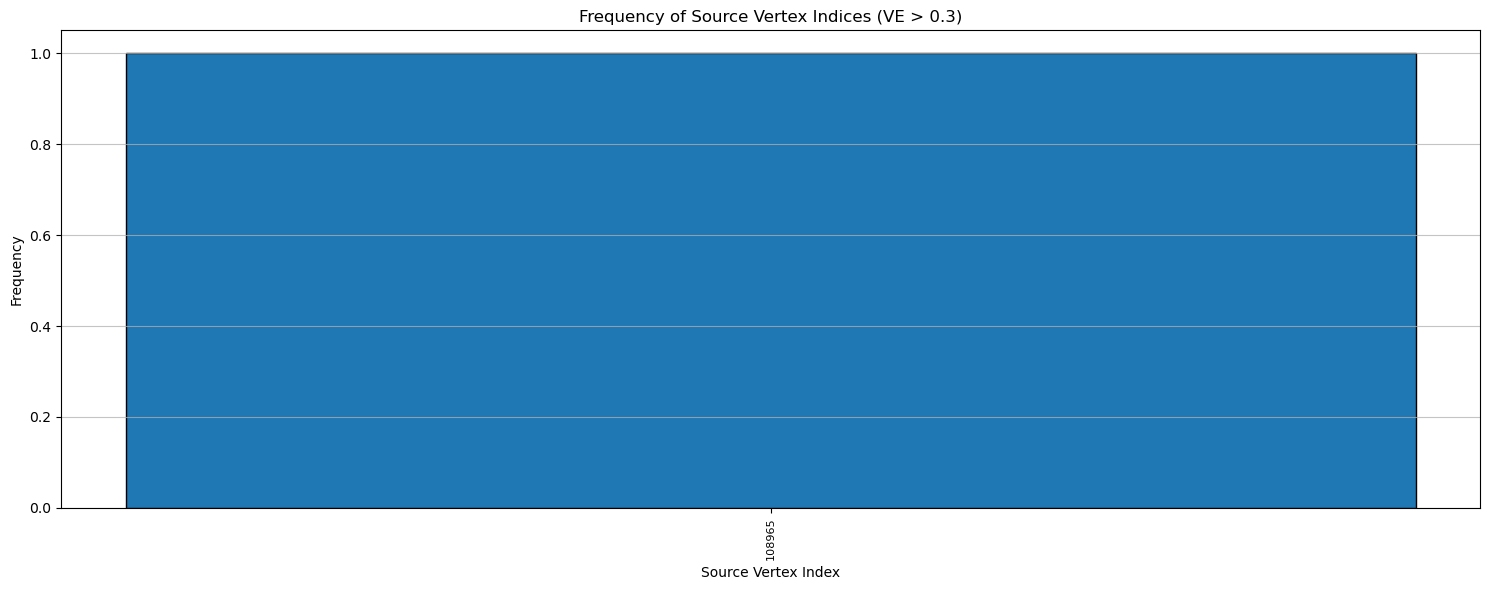

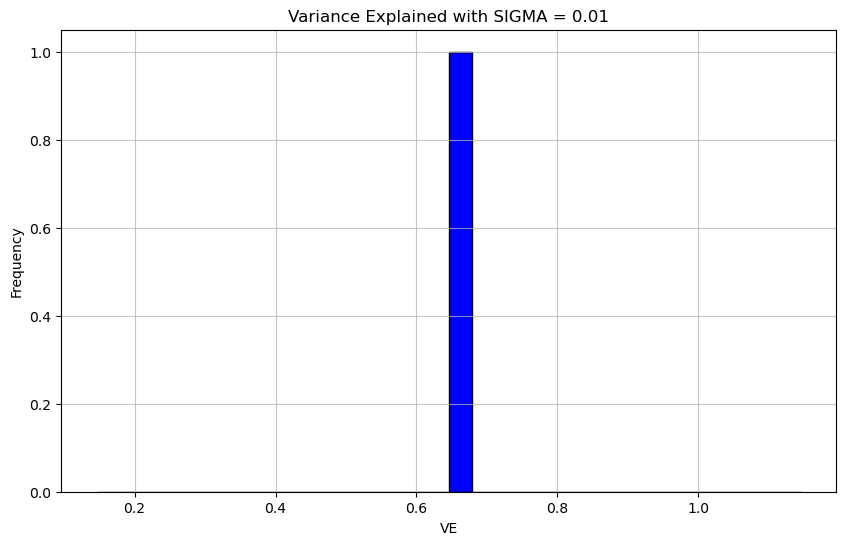

Loaded 2023 vertices from Visual Area 2.0 from /Volumes/FedericaCardillo/pre-processing/projects/PROJECT_EGRET-AAA/derivatives/freesurfer/sub-44/label/rh.manualdelin.label
Loaded 2074 vertices from Visual Area 1.0 from /Volumes/FedericaCardillo/pre-processing/projects/PROJECT_EGRET-AAA/derivatives/freesurfer/sub-44/label/rh.manualdelin.label


In [54]:
def sigma_vertices(file_path, output_path, sigma_value = 0.01): 
    best_fit = pd.read_csv(file_path)
    best_fit_sigma = best_fit[best_fit['Best Sigma'] == sigma_value][['Target Vertex Index', 'Source Vertex Index', 'Best Variance Explained']]
    best_fit_sigma.to_csv(output_path, index = False)
    return best_fit_sigma

def count_sigma_vertices(best_fit_sigma):
    # Filter to include only VE > 0.3
    filtered_sigma = best_fit_sigma[best_fit_sigma['Best Variance Explained'] > 0.3]
    unique_source_vertices = filtered_sigma['Source Vertex Index'].nunique() # Count unique source vertices
    print(f"Total amount of unique source vertices with VE > 0.3: {unique_source_vertices}")
    vertex_counts = filtered_sigma['Source Vertex Index'].value_counts().sort_index() # Count frequency of each Source Vertex Index
    vertex_indices = vertex_counts.index.astype(str)
    plt.figure(figsize=(15, 6))
    plt.bar(vertex_indices, vertex_counts.values, edgecolor='black')
    plt.title('Frequency of Source Vertex Indices (VE > 0.3)')
    plt.ylabel('Frequency')
    plt.xlabel("Source Vertex Index")
    plt.xticks(rotation=90, fontsize=8)  # Rotate x-axis labels for readability
    plt.grid(axis='y', alpha=0.75)
    plt.tight_layout()  # Adjust layout
    plt.show()

    return unique_source_vertices

def ve_sigma(best_fit_sigma):
    plt.figure(figsize=(10,6))
    plt.hist(best_fit_sigma['Best Variance Explained'], bins=30, color='blue', edgecolor='black')
    plt.title('Variance Explained with SIGMA = 0.01')
    plt.xlabel('VE')
    plt.ylabel('Frequency')
    plt.grid(alpha=0.75)
    plt.show()

def sigma_label(best_fit_sigma, output_label_path, source_vertices, hemi, supervoxel=supervoxel):
    filtered_df = best_fit_sigma[best_fit_sigma['Best Variance Explained'] > 0.3]
    if supervoxel:
        # Count frequency of each Source Vertex Index
        vertex_counts = filtered_df['Source Vertex Index'].value_counts()
        high_freq_vertices = vertex_counts[vertex_counts > 10].index # Filter vertices with frequency > 10
        unique_source_vertices = filtered_df[filtered_df['Source Vertex Index'].isin(high_freq_vertices)]['Source Vertex Index'].unique()
        output_label_path = output_label_path.replace('.label', '_supervoxel.label') # Update output path for supervoxel
    else:
        unique_source_vertices = filtered_df['Source Vertex Index'].unique()
    
    # Write label file
    with open(output_label_path, 'w') as label_file:
        label_file.write(f"#!ascii label, from subject vox2ras=TkReg\n")
        label_file.write(f"{len(unique_source_vertices)}\n")
        for vertex_idx in unique_source_vertices:
            vertex = source_vertices.get(vertex_idx)
            x, y, z = vertex.x, vertex.y, vertex.z
            scalar = 1.0
            label_file.write(f"{vertex.index} {x:.6f} {y:.6f} {z:.6f} {scalar:.6f}\n")

def sigma_label_target(best_fit_sigma, output_label_path, target_vertices, hemi, supervoxel=supervoxel):
    if supervoxel:
        filtered_df = best_fit_sigma[best_fit_sigma['Best Variance Explained'] > 0.3] # Filter by Best Variance Explained > 0.3
        source_vertex_counts = filtered_df['Source Vertex Index'].value_counts() # Count frequency of Source Vertex Index
        high_freq_sources = source_vertex_counts[source_vertex_counts > 10].index # Select source vertices with frequency > 10
        # Only rows with high-frequency source vertices
        filtered_df = filtered_df[filtered_df['Source Vertex Index'].isin(high_freq_sources)]
        unique_target_vertices = filtered_df['Target Vertex Index'].unique() # Extract unique target vertex indices after filtering
        output_label_path = output_label_path.replace('.label', '_supervoxel.label') # Update output file name for supervoxel
    else:
        filtered_df = best_fit_sigma[best_fit_sigma['Best Variance Explained'] > 0.3]
        unique_target_vertices = filtered_df['Target Vertex Index'].unique()

    # Write label file
    with open(output_label_path, 'w') as label_file:
        label_file.write(f"#!ascii label, from subject, vox2ras=TkReg\n")
        label_file.write(f"{len(unique_target_vertices)}\n")
        for vertex_idx in unique_target_vertices:
            vertex = target_vertices.get(vertex_idx)
            x, y, z = vertex.x, vertex.y, vertex.z
            scalar = 2.0  
            label_file.write(f"{vertex.index} {x:.6f} {y:.6f} {z:.6f} {scalar:.6f}\n")

def observed_vs_predicted(filtered_df, target_time_course, source_time_course, distance_matrix, plot_dir):
    os.makedirs(output_dir, exist_ok=True) # Create output directory 

    for _, row in filtered_df.iterrows(): # Iterate over best fit
        target_vertex_idx = row['Target Vertex Index'] # Extract target
        source_vertex_idx = row['Source Vertex Index'] # Extract source
        variance_explained = row['Best Variance Explained'].round(1)
        observed = target_time_course.tSeries.get(target_vertex_idx) # Get the observed time series for the target 

        distances = distance_matrix.loc[:, source_vertex_idx].values
        weights = np.exp(-distances / (2 * 0.01 ** 2))
        weights = weights / np.sum(weights, axis=0)
        source_vertex_indices = distance_matrix.columns.values
        source_series_matrix = np.array([source_time_course.tSeries.get(v_idx) for v_idx in source_vertex_indices])
        source_series_matrix = source_series_matrix.T
        predicted = np.dot(source_series_matrix, weights)

        # Plot observed and predicted time series
        plt.figure(figsize=(12, 6))
        plt.plot(observed, label='Observed Time Series', color='blue', linestyle='-', marker='o', alpha=0.7)
        plt.plot(predicted, label='Predicted Time Series', color='red', linestyle='--', marker='x', alpha=0.7)
        plt.title(f"Observed vs Predicted Time Series\nTarget Vertex {target_vertex_idx} and {source_vertex_idx} and VE = {variance_explained}")
        plt.xlabel("Time Points")
        plt.ylabel("BOLD Signal")
        plt.legend()
        plt.grid(True)
        plot_filename = f"{target_vertex_idx}_.png"
        plot_path = os.path.join(output_dir, plot_filename)
        plt.savefig(plot_path)
        plt.close()

def merged_sigma_to_surface(best_fit_sigma, freesurfer_dir, subj, hemi, target, source, supervoxel=True, mode='target'):
    filtered_df = best_fit_sigma[best_fit_sigma['Best Variance Explained'] > 0.3] # Apply filtering based on Best Variance Explained > 0.3
    if supervoxel:
        vertex_counts = filtered_df['Source Vertex Index'].value_counts() # Count frequency of each Source Vertex Index
        high_freq_vertices = vertex_counts[vertex_counts > 10].index # Filter vertices with frequency > 10
        filtered_df = filtered_df[filtered_df['Source Vertex Index'].isin(high_freq_vertices)] # Filter dataframe to only include high-frequency source vertices
    curv = read_morph_data(f'{freesurfer_dir}/{subj}/surf/{hemi}.curv')
    masked_data = np.full(curv.shape[0], -1.0)  # Initialize with -1 for unassigned vertices

    if mode == 'target':
        target_idx = filtered_df['Target Vertex Index'].values.astype(int) # Extract filtered target and source indices
        best_source_idx = filtered_df['Source Vertex Index'].values.astype(int)
        for t_idx, s_idx in zip(target_idx, best_source_idx): # Assign raw source indices directly 
            masked_data[t_idx] = s_idx
        output_name = f'{hemi}.{target}_to_{source}'
    else:        
        source_idx = filtered_df['Source Vertex Index'].values.astype(int) # Extract filtered source vertex indices
        
        for s_idx in source_idx:         # Assign source indices directly
            masked_data[s_idx] = s_idx
        print(masked_data[masked_data != -1])

        output_name = f'{hemi}.{target}_source_to_{source}'

    suffix = '_supervoxel' if supervoxel else ''
    output_path = f'{freesurfer_dir}/{subj}/surf/{output_name}{suffix}'
    write_morph_data(output_path, masked_data)

def sigma_frequency(best_fit_sigma, freesurfer_dir, subj, hemi, output_name, supervoxel=True):
    filtered_df = best_fit_sigma[best_fit_sigma['Best Variance Explained'] > 0.3] # Filter the dataframe for VE > 0.
    if supervoxel:
        vertex_counts = filtered_df['Source Vertex Index'].value_counts() # Count frequency of each Source Vertex Index
        high_freq_vertices = vertex_counts[vertex_counts > 10].index # Filter vertices with frequency > 10
        filtered_df = filtered_df[filtered_df['Source Vertex Index'].isin(high_freq_vertices)]
        vertex_counts = filtered_df['Source Vertex Index'].value_counts()  # Re-count after filtering

    
    curv = read_morph_data(f'{freesurfer_dir}/{subj}/surf/{hemi}.curv') # Initialize the surface with -1 (unassigned)
    frequency_data = np.full(curv.shape[0], -1.0)
    for vertex_idx, freq in vertex_counts.items(): # Assign frequency values to source vertices
        frequency_data[vertex_idx] = freq
    suffix = '_supervoxel' if supervoxel else ''
    output_path = f'{freesurfer_dir}/{subj}/surf/{output_name}{suffix}'
    write_morph_data(output_path, frequency_data) # Write the frequency data to surface

from vertex import Vertex

if __name__ == "__main__":
    freesurfer = f"{MAIN_PATH}/freesurfer"
    hemi = 'lh'
    subj = 'sub-46'
    target = 'V2'
    target_visal_area = 2.0000000000 # 2.0000000000
    source_visal_area = 1.0000000000 # 1.0000000000
    source = 'V1'
    input_file = f"/Users/federicacardillo/Documents/GitHub/OBJ_MCMC_CF/OBJ_MCMC_CF/results/{subj}/{hemi}/{target}->{source}/best_fits.csv" 
    fs_dir = f'/Volumes/FedericaCardillo/pre-processing/projects/PROJECT_EGRET-AAA/derivatives/freesurfer/{subj}/label'
    output_file = f"{fs_dir}/{target}_sigma_0.01.csv"
    label_file_path = f"{fs_dir}/{target}_source_sigma_0.01.label"
    target_label_file_path = f"{fs_dir}/{target}_target_sigma_0.01.label"
    supervoxel = True
    load_one = False

    # Extract the information for best fits with sigma = 0.01 
    best_fit_sigma = sigma_vertices(input_file, output_file)
    # Extract how many vertices have a sigma = 0.01
    count_sigma_vertices(best_fit_sigma)
    # VE histogram of sigma = 0.01
    ve_sigma(best_fit_sigma)
    
    # Create a label with the source vertex indices with sigma = 0.01
    idxTarget = Vertex.load_vertices(labels, target_visal_area, load_one)
    idxSource = Vertex.load_vertices(labels, source_visal_area, load_one)
    source_vertices = {v.index: v for v in idxSource}
    sigma_label(best_fit_sigma, label_file_path, source_vertices, hemi)
    # Create a label with the target vertex indices with sigma = 0.01
    target_vertices = {v.index: v for v in idxTarget}
    sigma_label_target(best_fit_sigma=best_fit_sigma, output_label_path=target_label_file_path, target_vertices=target_vertices, hemi=hemi) 

    output_name= f"{target}_heatmap.label"

    # merged_sigma_to_surface(best_fit_sigma, freesurfer_dir=freesurfer, subj=subj, hemi=hemi, target='target_label', source='source_label', supervoxel=True, mode='target')
    # merged_sigma_to_surface(best_fit_sigma, freesurfer_dir=freesurfer, subj=subj, hemi=hemi, target='target_label', source='source_label', supervoxel=True, mode='source')
    sigma_frequency(best_fit_sigma, freesurfer_dir=freesurfer, subj=subj, hemi=hemi, output_name= output_name, supervoxel=True)
    #observed_vs_predicted(best_fit_sigma, target_time_course, source_time_course, distance_matrix, plot_dir=plot_dir)

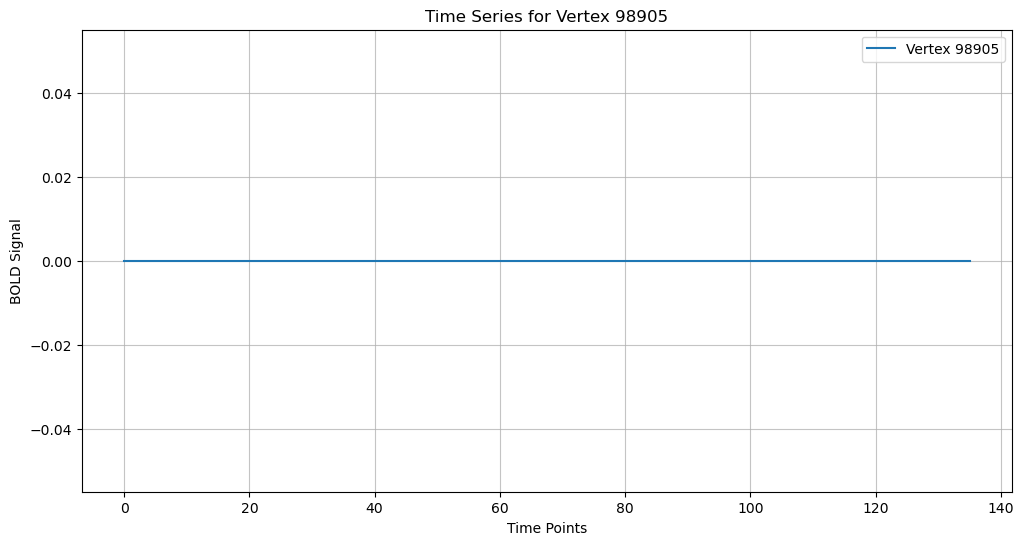

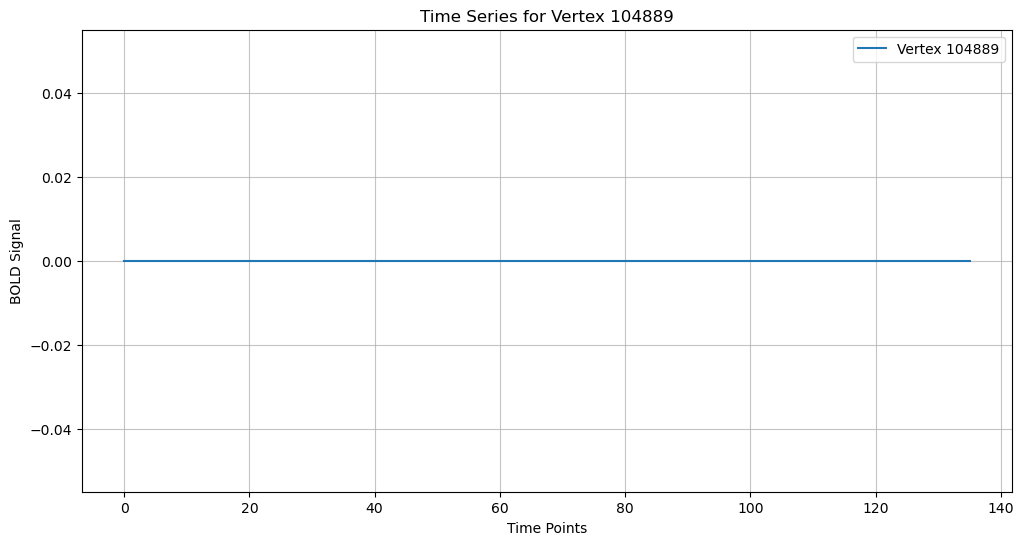

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Define the file path for the numpy array
MAIN_PATH = '/Volumes/FedericaCardillo/pre-processing/projects/PROJECT_EGRET-AAA/derivatives'
subj = 'sub-46'
ses = 'ses-02'
denoising = 'nordic'
time_series_path = f"{MAIN_PATH}/pRFM/{subj}/{ses}/{denoising}/{subj}_{ses}_task-RET_hemi-LR_desc-avg_bold_GM.npy"

time_series_data = np.load(time_series_path)
time_series_data = np.load(time_series_path).T 
vertices_of_interest = [98905, 104889]
time_series_vertex_1 = time_series_data[vertices_of_interest[0], :]
time_series_vertex_2 = time_series_data[vertices_of_interest[1], :]

# Plot time series for Vertex 98905
plt.figure(figsize=(12, 6))
plt.plot(time_series_vertex_1, label='Vertex 98905')
plt.title('Time Series for Vertex 98905')
plt.xlabel('Time Points')
plt.ylabel('BOLD Signal')
plt.legend()
plt.grid(alpha=0.75)
plt.show()

# Plot time series for Vertex 104889
plt.figure(figsize=(12, 6))
plt.plot(time_series_vertex_2, label='Vertex 104889')
plt.title('Time Series for Vertex 104889')
plt.xlabel('Time Points')
plt.ylabel('BOLD Signal')
plt.legend()
plt.grid(alpha=0.75)
plt.show()